In [2]:
import pandas as pd
import numpy as np

movie_annotation = pd.read_csv('utils/movie_scrambled_english_annotation.csv')
# Split the annotation into 3 annotators
annotation_1 = movie_annotation['Annotation RJH->KWJ->KTL'][:1200][np.arange(0,1200)%4==0].tolist()

In [6]:
len(annotation_1)

300

In [ ]:
# Generate NSP values from pretrained BERT model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

save = False
if save:
    import tqdm
    from transformers import BertTokenizer, BertForNextSentencePrediction
    import torch

    movie_annotation = pd.read_csv('utils/movie_scrambled_english_annotation.csv')
    # Split the annotation into 3 annotators
    annotation_1 = movie_annotation['Annotation RJH->KWJ->KTL'][:1200][np.arange(0,1200)%4==0].tolist()
    annotation_2 = movie_annotation['Annotation RJH->KWJ->KTL'][:1200][np.arange(0,1200)%4==1].tolist()
    annotation_3 = movie_annotation['Annotation RJH->KWJ->KTL'][:1200][np.arange(0,1200)%4==2].tolist()

    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', output_attentions=True)
    model = BertForNextSentencePrediction.from_pretrained('bert-base-uncased')
    model.to('cuda')
    model.eval()

    BERT_NSP_matrix = np.zeros((3, 300, 300))
    for a, annotation in enumerate([annotation_1, annotation_2, annotation_3]):
        print(f'annotator: {a}')
        for i in tqdm.tqdm(range(300)):
            for j in range(300):
                inputs = tokenizer(annotation[i], annotation[j], return_tensors='pt').to('cuda')
                with torch.no_grad():
                    outputs = model(**inputs)
                # NSP values are stored in the last layer of the model
                BERT_NSP_matrix[a, i, j] = outputs.logits[0][0].detach().cpu().numpy()
    np.save('_DATA/BERT_NSP_values.npy', BERT_NSP_matrix)
else:
    BERT_NSP_matrix = np.load('_DATA/BERT_NSP_values.npy')

In [ ]:
# Generate semantic similarity using Universal Sentence Encoder (USE)
save = False
if save:
    # I do not recommend running this code on your local machine, if you're not familiar with TensorFlow
    # final result is saved in _DATA/semantic_similarity_values.npy

    import tensorflow as tf
    import tensorflow_hub as hub

    movie_annotation = pd.read_csv('utils/movie_scrambled_english_annotation.csv')
    annotation_1 = movie_annotation['Annotation RJH->KWJ->KTL'][:1200][np.arange(0,1200)%4==0].tolist()
    annotation_2 = movie_annotation['Annotation RJH->KWJ->KTL'][:1200][np.arange(0,1200)%4==1].tolist()
    annotation_3 = movie_annotation['Annotation RJH->KWJ->KTL'][:1200][np.arange(0,1200)%4==2].tolist()

    module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
    model = hub.load(module_url)

    semantic_similarity_matrix = np.zeros((3,300,300))
    for a, annotation in enumerate([annotation_1, annotation_2, annotation_3]):
        annotation_embedding = np.zeros((300, 512))
        for i in range(300): # 300 sentences
            embedding = model(annotation).numpy()
            annotation_embedding[i,:] = embedding
        semantic_similarity_matrix[a,:,:] = np.corrcoef(annotation_embedding)
    np.save('_DATA/semantic_similarity_values.npy', semantic_similarity_matrix)
else:
    semantic_similarity_matrix = np.load('_DATA/semantic_similarity_values.npy')

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import lstsq

BERT_NSP_matrix = np.load('_DATA/BERT_NSP_values.npy')
semantic_similarity_matrix = np.load('_DATA/semantic_similarity_values.npy')

BERT_NSP_matrix_for_plotting = np.mean(BERT_NSP_matrix, axis=0)
BERT_NSP_matrix_for_plotting[np.tril_indices(300)] = np.nan
semantic_similarity_matrix_for_plotting = np.mean(semantic_similarity_matrix, axis=0)
semantic_similarity_matrix_for_plotting[np.tril_indices(300)] = np.nan

# Remove the semantic similarity from BERT NSP values
BERT_NSP_matrix_wo_similarity = np.zeros((3,300,300))
for i in range(3):
    semantic_similarity_vector = semantic_similarity_matrix[i,:,:].reshape(-1,1)
    NSP_vector = BERT_NSP_matrix[i,:,:].reshape(-1,1)

    X = np.concatenate([semantic_similarity_vector, np.ones(semantic_similarity_vector.shape)], axis=1)

    coef, residual, _, _ = lstsq(X, NSP_vector)
    nsp_vector_clean = NSP_vector - X.dot(coef)
    BERT_NSP_matrix_wo_similarity[i,:,:] = nsp_vector_clean.reshape((300,300))

BERT_NSP_matrix_wo_similarity = np.mean(BERT_NSP_matrix_wo_similarity, axis=0)
BERT_NSP_matrix_wo_similarity_for_plotting = np.copy(BERT_NSP_matrix_wo_similarity)
BERT_NSP_matrix_wo_similarity_for_plotting[np.tril_indices(300)] = np.nan
BERT_NSP_matrix_wo_similarity = np.repeat(np.repeat(BERT_NSP_matrix_wo_similarity, 2, axis=0), 2, axis=1)

NSP_matrix = np.repeat(np.repeat(np.mean(BERT_NSP_matrix, axis=0), 2, axis=0), 2, axis=1)
similarity_matrix = np.repeat(np.repeat(np.mean(semantic_similarity_matrix, axis=0), 2, axis=0), 2, axis=1)



NSP_values = np.zeros(600)
semantic_similarity = np.zeros(600)
narrative_coherence = np.zeros(600)
for i in range(1, 600):
    NSP_values[i] = np.max(NSP_matrix[:i,i])
    semantic_similarity[i] = np.max(similarity_matrix[:i,i])
    narrative_coherence[i] = np.max(BERT_NSP_matrix_wo_similarity[:i,i]) #/ (i+1)

from nltools.external import glover_hrf
hrf_weight = glover_hrf(tr=1, oversampling=1)

NSP_values = np.convolve(NSP_values, hrf_weight)[:610]
semantic_similarity = np.convolve(semantic_similarity, hrf_weight)[:610]
narrative_coherence = np.convolve(narrative_coherence, hrf_weight)[:610]


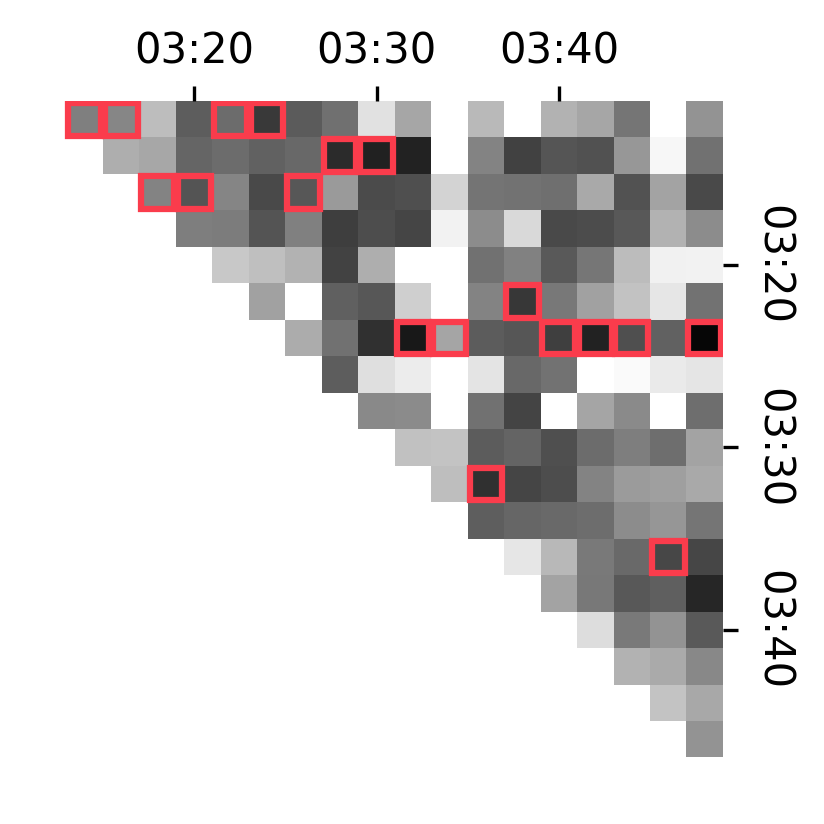

In [10]:
# Visualization of the narrative coherence
import matplotlib.patches as patches
plt.style.use('default')

def get_timeformat(seconds):
    m, s = divmod(seconds, 60)
    string = f'{m:02d}:{s:02d}'
    return string

# Just plot a limited range of the matrix for better visualization
fig, axes = plt.subplots(1,1,figsize=(3,3), dpi=300)
axes.imshow(BERT_NSP_matrix_wo_similarity_for_plotting, cmap='gray_r', vmin=-1.5, vmax=1.5)
for i in range(97, 115):
    max_idx = np.argmax(BERT_NSP_matrix_wo_similarity_for_plotting[96:i,i]) + 96
    rect = patches.Rectangle((i-0.45, max_idx-0.45), 0.9, 0.9, linewidth=1.5, edgecolor='#fa3c4c', facecolor='none')
    axes.add_patch(rect)
axes.set_xticks([100, 105, 110])
axes.set_yticks([100, 105, 110])
axes.set_xticklabels([get_timeformat(i*2) for i in [100, 105, 110]])
axes.set_yticklabels([get_timeformat(i*2) for i in [100, 105, 110]], rotation=270, va='center')
axes.set_xlim(95.5,114.5)
axes.set_ylim(114.5,95.5)
axes.xaxis.tick_top()
axes.yaxis.tick_right()
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.spines['bottom'].set_visible(False)
axes.spines['left'].set_visible(False)

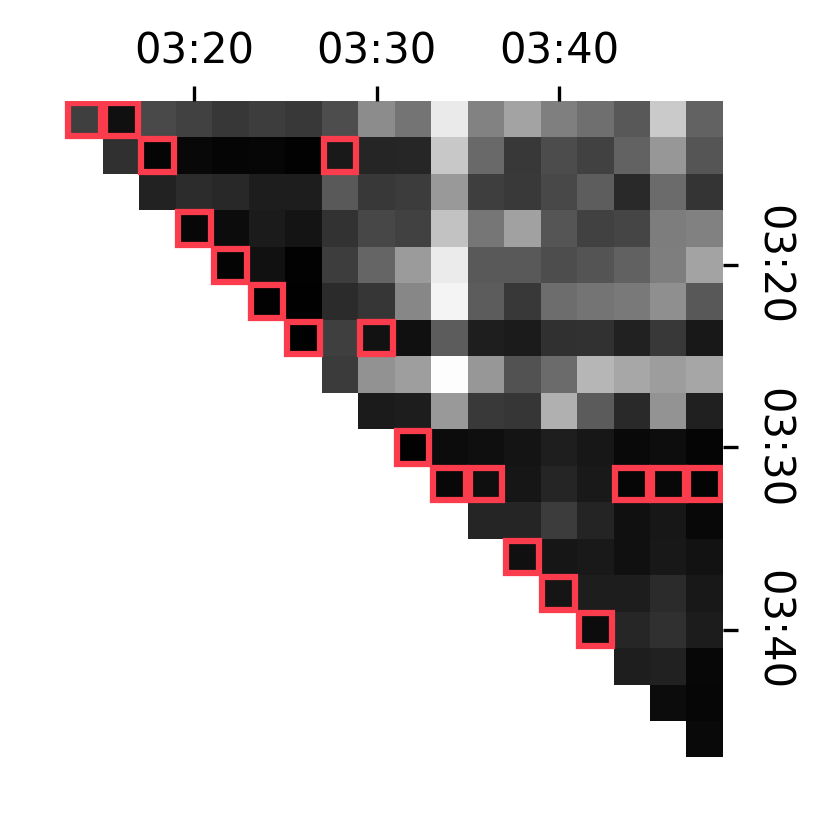

In [11]:
# Visualization of the NSP values
fig, axes = plt.subplots(1,1,figsize=(3,3), dpi=300)
axes.imshow(BERT_NSP_matrix_for_plotting, cmap='gray_r', vmin=1.5, vmax=6.5)
for i in range(97, 115):
    max_idx = np.argmax(BERT_NSP_matrix_for_plotting[96:i,i]) + 96
    rect = patches.Rectangle((i-0.45, max_idx-0.45), 0.9, 0.9, linewidth=1.5, edgecolor='#fa3c4c', facecolor='none')
    axes.add_patch(rect)
axes.set_xticks([100, 105, 110])
axes.set_yticks([100, 105, 110])
axes.set_xticklabels([get_timeformat(i*2) for i in [100, 105, 110]])
axes.set_yticklabels([get_timeformat(i*2) for i in [100, 105, 110]], rotation=270, va='center')
axes.set_xlim(95.5,114.5)
axes.set_ylim(114.5,95.5)
axes.xaxis.tick_top()
axes.yaxis.tick_right()
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.spines['bottom'].set_visible(False)
axes.spines['left'].set_visible(False)

97 96
98 96
99 97
100 99
101 100
102 100
103 101
104 101
105 104
106 105
107 105
108 105
109 108
110 108
111 110
112 106
113 112
114 106


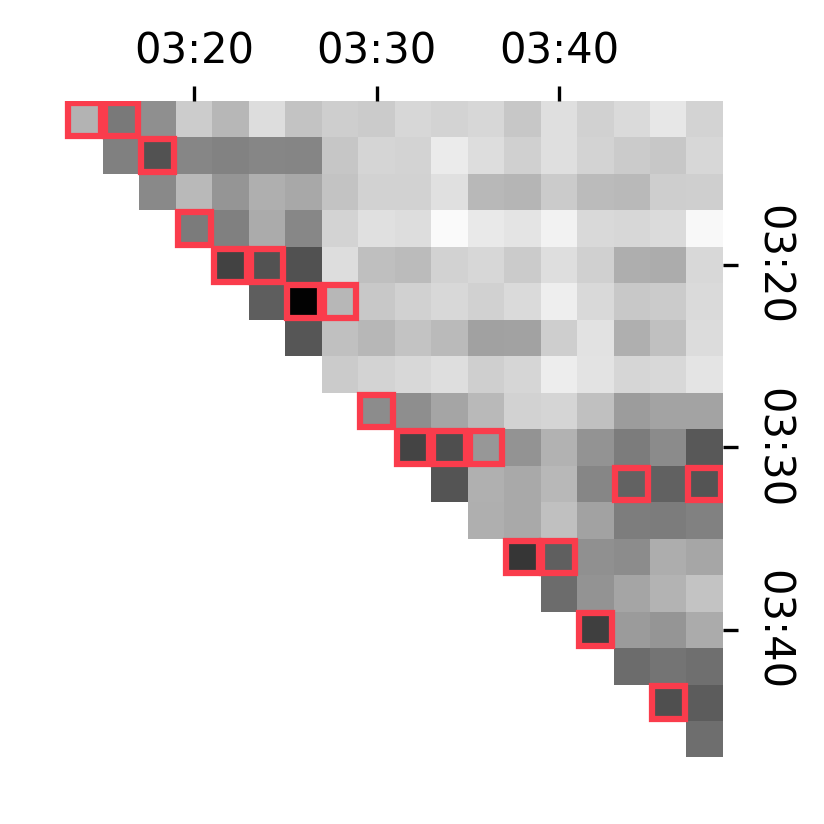

In [12]:
# Visualization of the semantic similarity

fig, axes = plt.subplots(1,1,figsize=(3,3), dpi=300)
axes.imshow(semantic_similarity_matrix_for_plotting, cmap='gray_r', vmin=0.0, vmax=0.8)
for i in range(97, 115):
    max_idx = np.argmax(semantic_similarity_matrix_for_plotting[96:i,i]) + 96
    print(i, max_idx)
    rect = patches.Rectangle((i-0.45, max_idx-0.45), 0.9, 0.9, linewidth=1.5, edgecolor='#fa3c4c', facecolor='none')
    axes.add_patch(rect)
axes.set_xticks([100, 105, 110])
axes.set_yticks([100, 105, 110])
axes.set_xticklabels([get_timeformat(i*2) for i in [100, 105, 110]])
axes.set_yticklabels([get_timeformat(i*2) for i in [100, 105, 110]], rotation=270, va='center')
axes.set_xlim(95.5,114.5)
axes.set_ylim(114.5,95.5)
axes.xaxis.tick_top()
axes.yaxis.tick_right()
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.spines['bottom'].set_visible(False)
axes.spines['left'].set_visible(False)

In [13]:
# Comparision of narrative coherence and level of narrative comprehension (Song et al., 2021)
from scipy.ndimage import gaussian_filter1d

response_time = np.load('utils/movie_aha_moment_Song_et_al_2021.npy')
response_timeframe = np.zeros(610)
for i in response_time:
    response_timeframe[int(i)] += 1
response_time_mean = gaussian_filter1d(response_timeframe, 6, mode='constant')
response_time_convolved = np.convolve(response_time_mean, hrf_weight, mode='full')[:610]

/tmp/ipykernel_1754405/2504483988.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(["", "", ""])


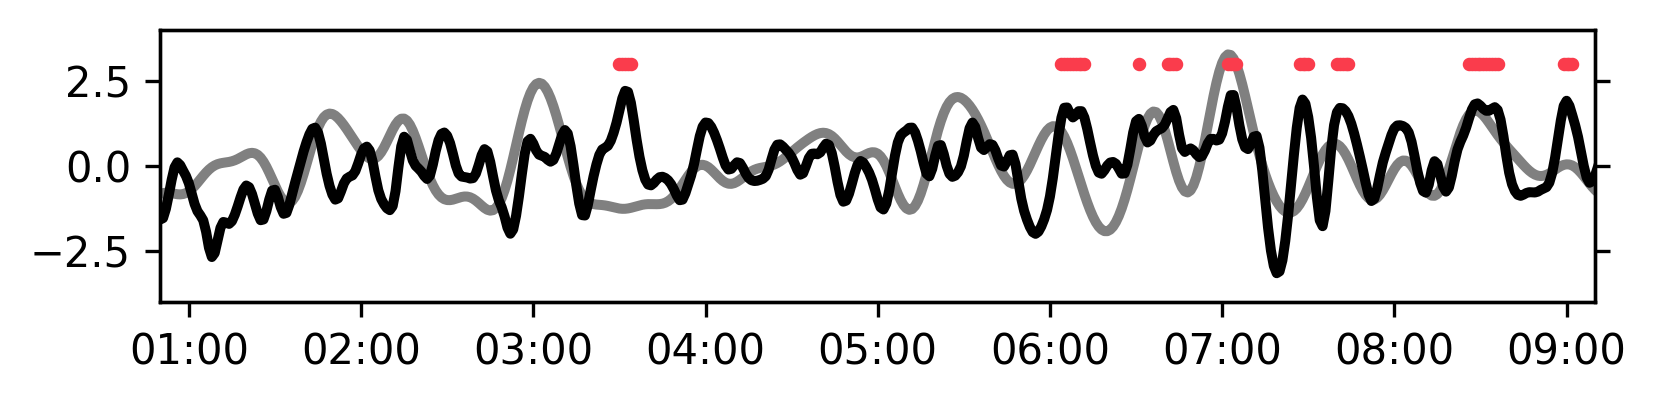

In [14]:
from scipy.stats import zscore
fig, ax1 = plt.subplots(figsize=(5.5,1.5), dpi=300)
plt.style.use('default')
x_indices = np.arange(0,610)[30:570]
ax1.plot(x_indices, zscore(response_time_convolved[x_indices]), lw=2.4, c='#808080')
ax2 = ax1.twinx()
ax2.plot(x_indices, zscore(narrative_coherence[x_indices]), c='k', lw=2.4,)

ax1.set_xticks(np.arange(0,610,60),[get_timeformat(s) for s in np.arange(0,610,60)])
for i in np.argsort(narrative_coherence)[::-1][:50]:
    ax1.scatter(i, 3.0, s=5, c='#fa3c4c', zorder=100)

ax1.set_ylim(-4,4)
ax2.set_ylim(-4,4)
ax2.set_yticklabels(["", "", ""])
ax1.set_xlim(50, 550)
fig.tight_layout()
plt.show()

In [17]:
from scipy.stats import pearsonr

n_permutation = 1000
np.random.seed(0)

x_indices = np.arange(0,610)[30:570] # Remove the edge effect
y = response_time_convolved
r_trues = [pearsonr(y[x_indices], x[x_indices])[0] for x in [narrative_coherence, NSP_values, semantic_similarity]]
r_trues = np.array(r_trues)

r_randoms = []
for j, x in enumerate([narrative_coherence, NSP_values, semantic_similarity]):
    r_randoms.append([])
    for i in range(n_permutation):
        response_time_shifted = np.roll(np.copy(response_time_mean), np.random.randint(0,610))
        response_time_shifted_convolved = np.convolve(response_time_shifted, hrf_weight, mode='full')[:610]
        r_randoms[j].append(pearsonr(response_time_shifted_convolved[x_indices], x[x_indices])[0])
r_randoms = np.array(r_randoms)

# Statistical significance
for j, x in enumerate([narrative_coherence, NSP_values, semantic_similarity]):
    print((1+np.sum(r_randoms[j]>=r_trues[j]))/(1+n_permutation))

0.015984015984015984
0.06693306693306693
0.2127872127872128


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


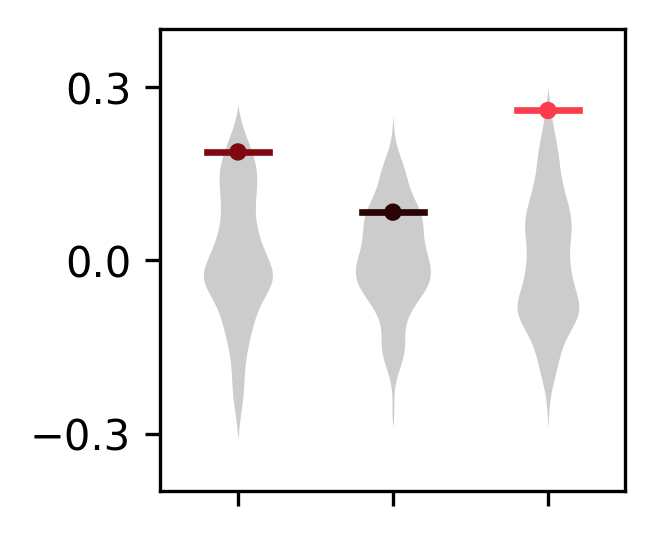

In [19]:
import pandas as pd
from matplotlib.collections import PolyCollection
from matplotlib.markers import MarkerStyle

def patch_violinplot():
     for art in ax.get_children():
          if isinstance(art, PolyCollection):
              art.set_edgecolor((1.0, 1.0, 1.0))

df = pd.DataFrame(data={'null':np.hstack([r_randoms[1], r_randoms[2], r_randoms[0]]), # NSP, semantic similarity, narrative coherence
                        'moments':np.hstack([["x1"]*1000 + ['x2']*1000 + ['x3']*1000])})

import seaborn as sns
plt.style.use('default')
color_palette = sns.color_palette("crest", 10)

fig, ax = plt.subplots(1, 1, figsize=(2,2), dpi=300, sharex=True, sharey=True)
width = 0.22
offset2 = 0.01
x = np.arange(3)

#color_list= [[0.2,0.2,0.2], [60/255,84/255,136/255]]*3
color_list= [0.0,0.0,0.0,0.2]
offset = 0.2
sns.violinplot(data=df, x='moments', y='null',
               ax=ax, width=0.5, inner=None, color="#777777",
               linewidth=0.6, zorder=1)
for i, v in enumerate(ax.findobj(PolyCollection)):
    v.set_facecolor(color_list)
color=['#800811', '#2b0305','#fa3c4c',]
ax.scatter([0,1,2], [r_trues[1], r_trues[2], r_trues[0]], s=10, c=color)
ax.plot([0-offset,0+offset], [r_trues[1], r_trues[1]], c='#800811', lw=1.6)
ax.plot([1-offset,1+offset], [r_trues[2], r_trues[2]], c='#2b0305', lw=1.6)
ax.plot([2-offset,2+offset], [r_trues[0], r_trues[0]], c='#fa3c4c', lw=1.6)

patch_violinplot()
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticklabels([])
ax.set_ylim(-0.4, 0.4)
ax.legend().set_visible(False)
ax.set_yticks([-0.3, 0.0, 0.3])

plt.xlim(-0.5,2.5)
plt.subplots_adjust(hspace=0.08)
plt.show()